In [6]:
from aux_func_V3 import *
import API_Numpy
import API_TensorFlow

import dill
import seaborn
import matplotlib.pyplot as plt
from IPython.display import clear_output
import h5py

In [7]:
def MalhaRetangular(N):
   Δ = 10.0/N
   Δx = Δ; Δy = Δ
   x = API_Numpy.arange(-5.0,5.0+Δx,Δx)
   y = API_Numpy.arange(-1.0,1.0,Δy)

   X = API_Numpy.stack([x]*y.shape[0],axis=1)
   Y = API_Numpy.stack([y]*x.shape[0],axis=0)

   return X, Y, Δ

def CondiçãoInicialShockEntropy2D(X, Y, γ,θ):
   R = API_Numpy.zeros(X.shape)
   P = API_Numpy.ones(X.shape)
   U = API_Numpy.zeros(X.shape)
   V = API_Numpy.zeros(X.shape)

   I = API_Numpy.ones(X.shape)

   l=X < -4
   r=X >=-4

   R[l]=I[l]*27.0/7.0
   U[l]=I[l]*4.0*API_Numpy.sqrt(35.0)/9.0
   P[l]=I[l]*31.0/3.0

   R[r] = 1.0 + API_Numpy.sin(X[r]*API_Numpy.cos(θ)*2.0*API_Numpy.pi + Y[r]*API_Numpy.sin(θ)*2.0*API_Numpy.pi)/5.0

   E = P/(γ-1.0) + R*(U**2 + V**2)/2.0
   Q0 = API_Numpy.stack([R, R*U, R*V, E],axis=0)
   return Q0

def CondiçãoInicialShockEntropy2D_N(N, γ,θ):
   X, Y, Δ = MalhaRetangular(N)
   Q0 = CondiçãoInicialShockEntropy2D(X, Y, γ,θ)
   return X, Y, Δ, Q0

def NullForce(Q,API):
   return 0.0

In [8]:
class ShockEntropy2DGhostPointsX:
    def __init__(self,γ,Δx,y,θ):
        self.γ=γ
        self.Δx=Δx
        self.y=y
        self.θ=θ
    def __call__(self,Q,API,t=None):
        ρl = 27.0/7.0
        ul = 4.0*API.cast(API.sqrt(35.0),'float64')/9.0
        pl = 31.0/3.0
        El = pl/(γ-1.0) + ρl*(ul**2)/2.0
        El = API.cast(El,'float64')

        raw_ref_shape=API.shape(Q)[:-3]
        out_shape=API.concat([API.shape(Q)[:-2],[3],API.shape(Q)[-1:]],axis=0)
        ref_shape=API.concat([API.ones(API.shape(raw_ref_shape),dtype='int32'),[4],[1],[1]],axis=0)

        vals_left=API.reshape([ρl, ρl*ul, 0.0, El],ref_shape)

        Xr = API.reshape([5.0+self.Δx, 5.0+2*self.Δx, 5.0+3*self.Δx], [3, 1])
        Yr = self.y[...,:3,:]
        ρr = 1.0 + API.sin(5.0*Xr*API.cos(self.θ) + 5.0*Yr*API.sin(self.θ))/5.0
        pr = API.ones(ρr.shape)
        ur = API.zeros(ρr.shape)
        vr = API.zeros(ρr.shape)
        Er = pr/(self.γ-1.0)
        Qr = API.stack([ρr, ur, vr, Er],axis=-3)

        Qg = [API.ones(out_shape,'float64')*API.cast(vals_left,'float64'),
        Q,
        API.cast(Qr,'float64')]

        return API.concat(Qg,-2)

def ShockEntropy2DGhostPointsY(Q,API,t=None):
    Qg = API.concat(
        [Q[...,:,-3:],
            Q,
            Q[...,:,:3]],axis=-1)
    return Qg

In [9]:
γ = 7.0/5.0
θ = API_Numpy.pi/6.0
N = 400
x, y, Δ, U0 = CondiçãoInicialShockEntropy2D_N(N, γ,θ)
Δx=Δ
cfl = 0.5
t_final = 1.8

GhostPointsX=ShockEntropy2DGhostPointsX(γ,Δx,y,θ)

In [10]:
with h5py.File(f"data_init_shock_entropy.h5", "w") as hf:
    hf.create_dataset('U0',data=U0)
    hf.create_dataset('γ',data=γ)
    hf.create_dataset('θ',data=θ)
    hf.create_dataset('x',data=x)
    hf.create_dataset('y',data=y)
    hf.create_dataset('Δ',data=Δ)
    hf.create_dataset('cfl',data=cfl)

In [11]:
WENO_Z_sim=simulation_2D(API_Numpy,
                        euler_equation_2D,
                        WENO_Z,
                        ε=1e-40,
                        γ=γ)

In [12]:
teste_X=WENO_Z_sim.equation.DerivadaEspacialX(U0, Δ, GhostPointsX, t=None)
teste_Y=WENO_Z_sim.equation.DerivadaEspacialY(U0, Δ, ShockEntropy2DGhostPointsY, t=None)

In [29]:
Ord = 5 # The order of the scheme
Q = GhostPointsX(U0,WENO_Z_sim.equation.API, t=0)

#N = Q.shape[1]

Qi=slicer_X(Q,6,WENO_Z_sim.equation.API)
Qi=WENO_Z_sim.equation.API.einsum('...ijkl->...jkil',Qi)

Λ = WENO_Z_sim.equation.EigenvaluesX(Qi)
M = WENO_Z_sim.equation.API.max(WENO_Z_sim.equation.API.abs(Λ),axis=(-1,-2),keepdims=True)
X_R, X_L = WENO_Z_sim.equation.EigensystemX(Qi)

Qi_X=Qi.copy()
Λ_X=Λ.copy()


In [30]:
Ord = 5 # The order of the scheme
Q = ShockEntropy2DGhostPointsY(U0,WENO_Z_sim.equation.API,t=0)

#N = Q.shape[1]

Qi=slicer_Y(Q,6,WENO_Z_sim.equation.API)
Qi=WENO_Z_sim.equation.API.einsum('...ijkl->...jkil',Qi)

Λ = WENO_Z_sim.equation.EigenvaluesY(Qi)
M = WENO_Z_sim.equation.API.max(WENO_Z_sim.equation.API.abs(Λ),axis=(-1,-2),keepdims=True)
Y_R, Y_L = WENO_Z_sim.equation.EigensystemY(Qi)

Qj_Y=Qi.copy()
Λ_Y=Λ.copy()

In [16]:
P=WENO_Z_sim.equation.Pressure_2D(U0)

In [177]:
P_julia.shape

(20, 101)

In [182]:
U0.shape

(4, 101, 20)

In [19]:
γ=WENO_Z_sim.equation.γ
Q1,Q2,Q3,Q4=WENO_Z_sim.API.unstack(U0,axis=-3)

a=WENO_Z_sim.equation.γ-1.0
b=Q2**2+Q3**2
c=2*Q1
d=b/c
e=Q4-d

In [193]:
γ

1.6666666666666667

In [191]:
np.max(np.abs(a*e-(γ-1)*(Q4 - (Q2**2+Q3**2) / Q1/2)))

0.0

In [188]:
(γ-1)*(Q4 - (Q2**2+Q3**2)/Q1/2)

array([[17.22222222, 17.22222222, 17.22222222, ..., 17.22222222,
        17.22222222, 17.22222222],
       [17.22222222, 17.22222222, 17.22222222, ..., 17.22222222,
        17.22222222, 17.22222222],
       [17.22222222, 17.22222222, 17.22222222, ..., 17.22222222,
        17.22222222, 17.22222222],
       ...,
       [ 1.66666667,  1.66666667,  1.66666667, ...,  1.66666667,
         1.66666667,  1.66666667],
       [ 1.66666667,  1.66666667,  1.66666667, ...,  1.66666667,
         1.66666667,  1.66666667],
       [ 1.66666667,  1.66666667,  1.66666667, ...,  1.66666667,
         1.66666667,  1.66666667]])

In [32]:
np.max(np.abs(Λ_X-Λ_X_julia))

4.440892098500626e-16

In [17]:
transp=[0,1,3,2]
with h5py.File("data_full_shock_entropy.h5", "r") as hf:
    Qi_X_julia=np.transpose(np.asarray(hf['Qi_X']).T,transp)
    Qj_Y_julia=np.transpose(np.asarray(hf['Qj_Y']).T,transp)
    Λ_X_julia=np.transpose(np.asarray(hf['Λ_X']).T,transp)
    Λ_Y_julia=np.transpose(np.asarray(hf['Λ_Y']).T,transp)
    X_R_julia=np.transpose(np.asarray(hf['X_r']).T,transp)
    X_L_julia=np.transpose(np.asarray(hf['X_l']).T,transp)
    Y_R_julia=np.transpose(np.asarray(hf['Y_r']).T,transp)
    Y_L_julia=np.transpose(np.asarray(hf['Y_l']).T,transp)
    P_julia=np.asarray(hf['P'])

In [41]:
with h5py.File("data_full_shock_entropy.h5", "r") as hf:
    teste_X_julia=np.asarray(hf['FluxDerivativeX'])
    teste_Y_julia=np.asarray(hf['FluxDerivativeY'])

In [51]:
teste_X_julia.shape

(4, 20, 101)

In [52]:
teste_X.shape

TensorShape([4, 101, 20])

In [49]:
np.transpose(teste_X_julia,[0,2,1]).shape

(20, 4, 101)

In [ ]:
for i in range(100):
    print(i)
    print(np.min(np.abs(teste_X-np.transpose(teste_X_julia,[0,2,1]))[1,i,:]))

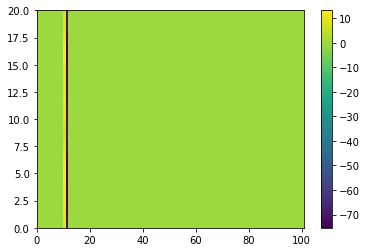

In [81]:
plt.pcolormesh((teste_X-np.transpose(teste_X_julia,[0,2,1]))[1].numpy().T)
plt.colorbar()
plt.show()

In [12]:
t=0
count=0
U=U0.copy()
while t<t_final:
    Λ  = WENO_Z_sim.equation.maximum_speed(U)
    Δt = Δ*cfl/Λ
    Δt = np.where(t+Δt>t_final,t_final-t,Δt)

    U=WENO_Z_sim.Sim_step(U, Δt, Δ, Δ, GhostPointsX, ShockEntropy2DGhostPointsY,NullForce)
    t+=Δt
    print(t,end='\r')

In [14]:
import h5py

f = h5py.File("data_julia.jld", "r")
data_julia=np.asarray(f['data']).transpose((0,2,1))

In [19]:
ref_U=np.abs(U-data_julia)
print(np.max(ref_U))

5.743817249741721


5.743817249741721


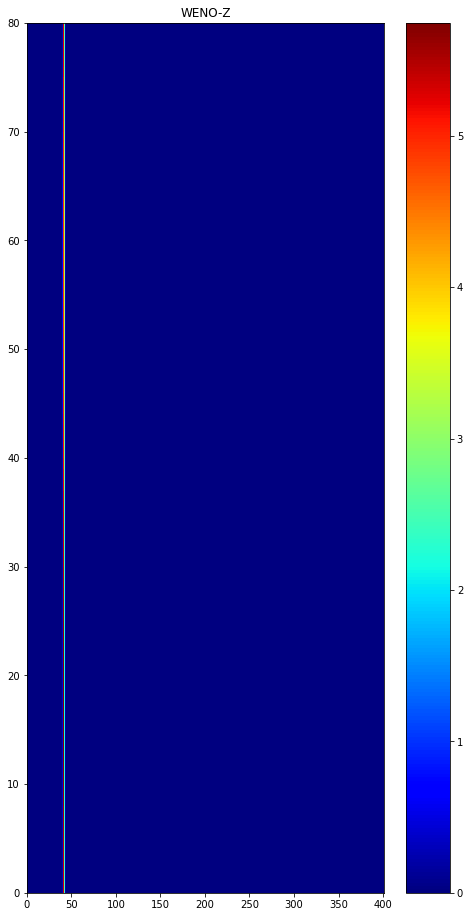

In [25]:
plt.figure(figsize=(8,16))
t=3
ref_U=np.abs(U[t]-data_julia[t])
print(np.max(ref_U))
a=plt.pcolormesh(ref_U.T,cmap='jet')
plt.colorbar(a)
plt.title('WENO-Z')
plt.show()

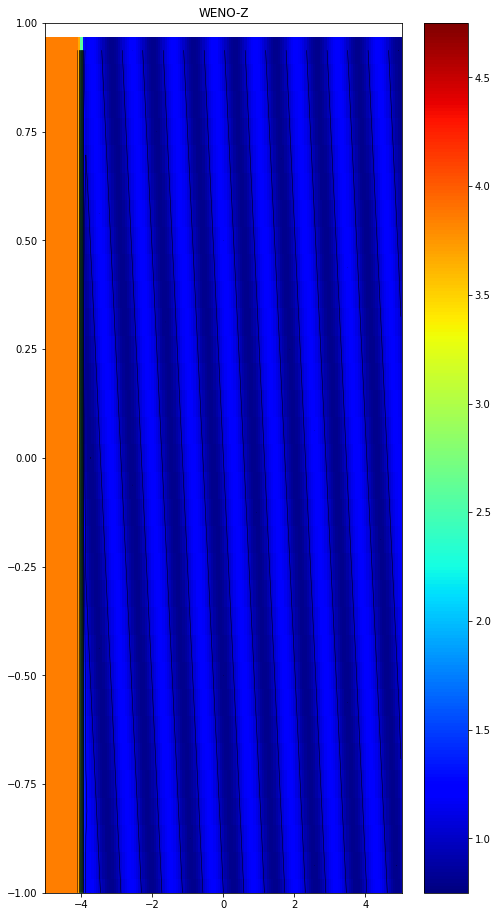

In [8]:
plt.figure(figsize=(8,16))
ref_U=U[0].numpy()
a=plt.pcolormesh(x.T,y.T,ref_U.T,cmap='jet',vmin=0.75,vmax=4.75)
plt.colorbar(a)
plt.contour(x.T,y.T,ref_U.T,levels=15,vmin=0.75,vmax=4.75,colors='black',linewidths=0.5)
plt.title('WENO-Z')
plt.ylim((-1,1))
plt.show()

In [47]:
for WENO_type,name in zip([
    WENO_Z_sim,
    WENO_Zp_sim,
    WENO_Z_MS_sim,
    WENO_Zp_MS_sim,
    WENO_Z_BI_sim,
    WENO_ZC_MS_sim,
    WENO_ZC_BI_sim
    ],
    [
    'WENO-Z',
    'WENO-Z+',
    'WENO-Z (MS)',
    'WENO-Z+ (MS)',
    'WENO-Z (BI)',
    'WENO-ZC (MS)',
    'WENO-ZC (BI)'
    ]):
    U=U0.copy()
    t=0
    count=0
    if not(os.path.isdir(f'imagens/shockdensity2D-{name}/')):
            os.mkdir(f'imagens/shockdensity2D-{name}/')
    if not(os.path.isdir(f'imagens/shockdensity2D-Zoom-{name}/')):
            os.mkdir(f'imagens/shockdensity2D-Zoom-{name}/')
    while t<t_final:
        Λ  = WENO_type.equation.maximum_speed(U)
        Δt = Δ*cfl/Λ
        Δt = np.where(t+Δt>t_final,t_final-t,Δt)

        U=WENO_type.Sim_step(U, Δt, Δ, Δ, ShockEntropy2DGhostPointsX, ShockEntropy2DGhostPointsY,NullForce)
        t+=Δt
        print(t,end='\r')
        plt.figure(figsize=(16,8))
        ref_U=U[0].numpy()
        a=plt.pcolormesh(x.T,y.T,ref_U.T,cmap='jet',vmin=0.75,vmax=4.75)
        plt.colorbar(a)
        plt.contour(x.T,y.T,ref_U.T,levels=15,vmin=0.75,vmax=4.75,colors='black',linewidths=0.5)
        plt.title(name)
        count+=1
        plt.savefig(f'imagens/shockdensity2D-{name}/{count}.png')
        plt.close()

        plt.figure(figsize=(16,8))
        ref_U=U[0].numpy()
        a=plt.pcolormesh(x.T,y.T,ref_U.T,cmap='jet',vmin=0.75,vmax=4.75)
        plt.colorbar(a)
        plt.contour(x.T,y.T,ref_U.T,levels=15,vmin=0.75,vmax=4.75,colors='black',linewidths=0.5)
        plt.title(name)
        count+=1
        plt.savefig(f'imagens/shockdensity2D-Zoom-{name}/{count}.png')
        plt.close()

    with open(name+'.bkp','wb') as file:
        dill.dump(U,file)

    plt.figure(figsize=(16,8))
    ref_U=U[0].numpy()
    a=plt.pcolormesh(x.T,y.T,ref_U.T,cmap='jet',vmin=0.75,vmax=4.75)
    plt.colorbar(a)
    plt.contour(x.T,y.T,ref_U.T,levels=15,vmin=0.75,vmax=4.75,colors='black',linewidths=0.5)
    plt.title(name)
    #plt.xlim((0,3))
    plt.savefig('shockdensity2D'+name+'.png')
    plt.close()

    plt.figure(figsize=(16,8))
    ref_U=U[0].numpy()
    a=plt.pcolormesh(x.T,y.T,ref_U.T,cmap='jet',vmin=0.75,vmax=4.75)
    plt.colorbar(a)
    plt.contour(x.T,y.T,ref_U.T,levels=15,vmin=0.75,vmax=4.75,colors='black',linewidths=0.5)
    plt.title(name)
    plt.xlim((0,3))
    plt.savefig('shockdensity2D-zoom'+name+'.png')
    plt.close()

In [44]:
for WENO_type,name in zip([
    WENO_Z_sim,
    WENO_Zp_sim,
    WENO_Z_MS_sim,
    WENO_Zp_MS_sim,
    WENO_Z_BI_sim,
    WENO_ZC_MS_sim,
    WENO_ZC_BI_sim
    ],
    [
    'WENO-Z',
    'WENO-Z+',
    'WENO-Z (MS)',
    'WENO-Z+ (MS)',
    'WENO-Z (BI)',
    'WENO-ZC (MS)',
    'WENO-ZC (BI)'
    ]):
    U=U0.copy()
    t=0
    count=0

    with open(name+'.bkp','rb') as file:
        U=dill.load(file)

    plt.figure(figsize=(16,8))
    ref_U=U[0].numpy()
    a=plt.pcolormesh(x.T,y.T,ref_U.T,cmap='jet',vmin=0.75,vmax=4.75)
    plt.colorbar(a)
    plt.contour(x.T,y.T,ref_U.T,levels=15,vmin=0.75,vmax=4.75,colors='black',linewidths=0.5)
    plt.title(name)
    #plt.xlim((0,3))
    plt.savefig('shockdensity2D'+name+'.png')
    plt.close()

In [18]:
API_Numpy.min(ref_U)

0.7887306367423698